In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as const
import pylab

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.colors as mpl_c
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


import sys
sys.path.insert(0, '/cosma8/data/dp317/dc-naza3/arepo-snap-util')
import arepo_run as arun
import gadget

gamma    = 5./3
unit_m   = 1.989e43
unit_v   = 1.e5
unit_l   = 3.09567758e21
unit_t   = unit_l/unit_v
unit_rho = unit_m/unit_l**3

/cosma8/data/dp317/dc-naza3/arepo-snap-util/gadget_snap.py:3810: SyntaxWarning: invalid escape sequence '\d'
  p = re.compile('\d\d\d')
/cosma8/data/dp317/dc-naza3/arepo-snap-util/gadget_snap.py:3840: SyntaxWarning: invalid escape sequence '\d'
  p = re.compile('\d\d\d')


In [ ]:
def number_string(snap):
    snap_str = str(snap)
    if len(snap_str) < 3:
        snap_str = (3-len(snap_str))*str(0)+snap_str
    return snap_str

def calc_snap_time(s):
    Length_unit = s.header['UnitLength_in_cm'] * u.cm
    Velocity_unit = s.header['UnitVelocity_in_cm_per_s'] * u.cm / u.s
    Time_unit = Length_unit / Velocity_unit
    Time = s.header['Time'] * Time_unit
    Time_Myr = Time.to(u.Myr)
    return Time_Myr


def get_vranges(snap_nums,snappath=None,quant='temp',flag_excl=True):
    minval = np.empty(0)
    maxval = np.empty(0)

    for i_s, num in enumerate(snap_nums):
        s = load_snap_data(num,snappath=output_path,snapbase=SNAPBASE)
        quant_data = s.data[quant]
        if flag_excl: #Exclude the BOLA cells
            quant_data = quant_data[s.data['flag']==0]
        minval = np.append(minval, quant_data.min())
        maxval = np.append(maxval, quant_data.max())
        #print('\n',s.data[quant].min(),s.data[quant].max())

    ranges = [minval.min(),maxval.max()]
    print('Min/max values at snaps:',minval.argmin(),minval.argmax())
    return ranges


def calc_mu(data,ionisation='ionised'):
    X = HYDROGENMASS_FRAC

    if 'metals' in data.keys():
        Z = data['metals'] ## metal mass fraction
    else:
        Z = 0

    if 'ne' in data.keys():
        ne = data['ne']
        print('\t>>Electrion density found, calculating mu...')
    elif ionisation == 'ionised':
        ne = np.ones_like(data['u']) * 2 / (1+X)
        print('\t>>Electron density not found, asssuming default ionisation: {}'.format(ionisation))
    elif ionisation =='neutral':
        ne = np.zeros_like(data['u'])
        print('\t>>Electron density not found, asssuming default ionisation: {}'.format(ionisation))

    mu = 4 / (X * (3 + 4*ne) + 1 - Z)
    return mu

def calc_T(data):
    temp = data['u']*(unit_v)**2 * (GAMMA - 1) * data['mu']  * m_p  / k_B
    print(temp)
    return temp

def calc_P(data):
    pressure = (data['rho']*unit_rho) * (data['u']*unit_v**2) * (GAMMA - 1)
    return pressure

def rho_to_n_cm(data):
    n_cms = data['rho'] * ((u.kpc**-3).to(u.cm**-3) / (m_p * data['mu']))
    return n_cms

def rho_to_nH_cm(data):
    nH_cm = HYDROGENMASS_FRAC * data['rho'] * (u.kpc**-3).to(u.cm**-3) / m_p
    return nH_cm


def calc_cooling(data, header, verbose=False):
    if 'coor' in data:
        ## Setup unit system
        length_unit = header['UnitLength_in_cm'] * u.cm
        velocity_unit = header['UnitVelocity_in_cm_per_s'] * u.cm / u.s
        mass_unit = header['UnitMass_in_g'] * u.g
        time_unit = length_unit / velocity_unit

        ## s.data['coor'] is the cooling rate per unit mass, in simulations units

        cool_time =  (time_unit * data['u'] / data['coor']).to(u.Myr)  ## Comes from io_fields.c
        cool_rate_mass = (data['coor'] * velocity_unit**3 / length_unit).to(u.erg / u.s / u.g)

        ratefact = (HYDROGENMASS_FRAC / (m_p * mass_unit))**2 * data['rho'] * mass_unit / length_unit**3
        cool_rate_volume = (cool_rate_mass/ratefact).to(u.erg/u.s * u.cm**3)

        return cool_time.value, cool_rate_mass.value, cool_rate_volume.value
    
    else:
        if verbose:
            print('\t>>Field COOR not found, skipping cooling calculation...')
        return None, None, None
    

def calc_bremsstrahlung(data,T_cut=None,gaunt_factor=1, Z_factor = 1):
    # See Sijacki & Springel 06, also Bennett
    # Bolometric X-ray (all bands)

    xray = np.zeros_like(data['temp'])

    vols = (data['vol']*u.kpc**3).to(u.cm**3).value
    xray =  1.4e-27 * gaunt_factor * Z_factor**2 * data['temp']**(0.5) * data['ne'] * data['nH_cm']**2 * (1-data['nh']) * vols

    if T_cut is not None:
        xray[data['temp']<T_cut] = 0

    return xray


def load_snap_data(num,snappath=None,snapbase='snap_',advanced_xrays=False,verbose=False,default_ionisation='ionised'):
    
    snapname = snappath + snapbase + number_string(num)
    print('\n>Loading snap',snapname+SNAPFILETYPE)

    o = arun.Run(snappath=snappath,snapbase=SNAPBASE)
    s = o.loadSnap(snapnum=num)

    s.data['mu'] = calc_mu(s.data,ionisation=default_ionisation)
    s.data['temp'] = calc_T(s.data)

    if 'pres' not in s.data:
        s.data['pres'] = calc_P(s.data)

    if 'wind' not in s.data and 'pass' in s.data:
        s.data['wind'] = s.data['pass']

    s.data['n_dens_cm'] = rho_to_n_cm(s.data)

    s.data['nH_cm'] = rho_to_nH_cm(s.data)
    xx = s.data['pos'][:,0] - s.boxsize/2.
    yy = s.data['pos'][:,1] - s.boxsize/2.
    zz = s.data['pos'][:,2] - s.boxsize/2.
    rr = np.sqrt(xx**2 + yy**2 + zz**2)
    s.data['r'] = rr

    vx = s.data['vel'][:,0]
    vy = s.data['vel'][:,1]
    vz = s.data['vel'][:,2]
    s.data['vrad'] = (vx * xx/rr + vy * yy/rr + vz * zz/rr)

    s.data['speed']     = np.linalg.norm(s.data['vel'], axis=1)
    

    if 'coor' in s.data:
        s.data['cool_time'], s.data['cool_rate_mass'], s.data['cool_rate_volume'] = calc_cooling(s.data, s.header)
    else:
        print('\t>>Field COOR not found, skipping cooling calculation...')
 
    if 'ne' in s.data:
        s.data['ne_cm'] = s.data['ne'] * s.data['nH_cm']
  
        s.data['xray'] = calc_bremsstrahlung(s.data)

    return s


def plot_quad_axis(
        s,
        fig,
        quad_subs,
        quad_ax_loc = [0,0],
        var = 'temp',
        weighted = 'rho', # or None
        ranges = None,
        cmap = 'viridis',
        logplot = True,
        divzero = False,
        divzero_centre = None,

        image_proj = 'side',
        proj_on = True,
        proj_fact = 0.1,
        res = 258,
        plotsize = 2,
        colorbar = True,
        ):


    ## Set up subplot
    quad_ax = plt.Subplot(fig, quad_subs[quad_ax_loc[0],quad_ax_loc[1]])
    fig.add_subplot(quad_ax)

    ## Calculate centre and set up viewing angle
    x_pol = -1 + 2*quad_ax_loc[1]
    y_pol = 1 - 2*quad_ax_loc[0]

    x_centre = s.boxsize/2 + x_pol*plotsize/2
    y_centre = s.boxsize/2 + y_pol*plotsize/2
    z_centre = s.boxsize/2

    if image_proj == 'side':
        plot_centre = [x_centre, z_centre, y_centre]
        axes_sum = [0,2]
    elif image_proj == 'top':
        plot_centre = [x_centre, y_centre, z_centre]
        axes_sum = [0,1]

    print(plot_centre)


    ## Call gadget_snap from arepo-snap-utils to plot in given axis

    if weighted is None:
        s.axplot_Aslice(quad_ax,value=var,cmap=cmap,colorbar=colorbar,divzero=divzero,divzero_centre=divzero_centre,vrange=ranges,axes=axes_sum,logplot=logplot,box=[plotsize,plotsize],center=plot_centre,proj=proj_on,proj_fact=proj_fact,res=res)
    else:
        s.axplot_Aweightedslice(quad_ax,value=var,weights=weighted,cmap=cmap,colorbar=colorbar,divzero=divzero,divzero_centre=divzero_centre,vrange=ranges,axes=axes_sum,logplot=logplot,box=[plotsize,plotsize],center=plot_centre,proj=proj_on,proj_fact=proj_fact,res=res)

    ## Set axis labels relative to centre of box

    quad_ax.set_xticklabels(quad_ax.get_xticks()-s.boxsize/2)
    quad_ax.set_yticklabels(quad_ax.get_yticks()-s.boxsize/2)

    ## Tidy up axis edges and labels

    if quad_ax_loc[0] == 0:
        quad_ax.spines['bottom'].set_visible(False)
        quad_ax.set_xticks([])
    if quad_ax_loc[0] == 1:
        quad_ax.spines['top'].set_visible(False)
    if quad_ax_loc[1] == 1:
        quad_ax.spines['left'].set_visible(False)
        quad_ax.set_yticks([])

    return quad_ax





    


>Loading snap /cosma8/data/dp317/dc-naza3/gasCloudNfw/output/snap_010.hdf5
	>>Electron density not found, asssuming default ionisation: ionised
[352762.5  326079.97 347697.9  ... 237362.05 207684.98 178162.45]
	>>Field COOR not found, skipping cooling calculation...
[475.0, 500.0, 525.0]
Selected 7626 of 2333973 particles.
nz= 204 zdist=0.00420453, boxx=50.000000, boxy=50
Plot range [500000.0, 1000000000.0]


/tmp/ipykernel_935960/359559692.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  quad_ax.set_xticklabels(quad_ax.get_xticks()-s.boxsize/2)
/tmp/ipykernel_935960/359559692.py:210: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  quad_ax.set_yticklabels(quad_ax.get_yticks()-s.boxsize/2)


[475.0, 500.0, 475.0]
Selected 7602 of 2333973 particles.
nz= 204 zdist=0.00420453, boxx=50.000000, boxy=50
Plot range [1e-08, 0.00012426625471562147]


/tmp/ipykernel_935960/359559692.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  quad_ax.set_xticklabels(quad_ax.get_xticks()-s.boxsize/2)
/tmp/ipykernel_935960/359559692.py:210: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  quad_ax.set_yticklabels(quad_ax.get_yticks()-s.boxsize/2)


[525.0, 500.0, 525.0]
Selected 7657 of 2333973 particles.
nz= 204 zdist=0.00420453, boxx=50.000000, boxy=50
Plot range [1e-08, 4989.48681640625]


/tmp/ipykernel_935960/359559692.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  quad_ax.set_xticklabels(quad_ax.get_xticks()-s.boxsize/2)
/tmp/ipykernel_935960/359559692.py:210: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  quad_ax.set_yticklabels(quad_ax.get_yticks()-s.boxsize/2)


[525.0, 500.0, 475.0]
Selected 7624 of 2333973 particles.
nz= 204 zdist=0.00420453, boxx=50.000000, boxy=50
Plot range [1e-08, 1.0]


/tmp/ipykernel_935960/359559692.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  quad_ax.set_xticklabels(quad_ax.get_xticks()-s.boxsize/2)
/tmp/ipykernel_935960/359559692.py:210: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  quad_ax.set_yticklabels(quad_ax.get_yticks()-s.boxsize/2)


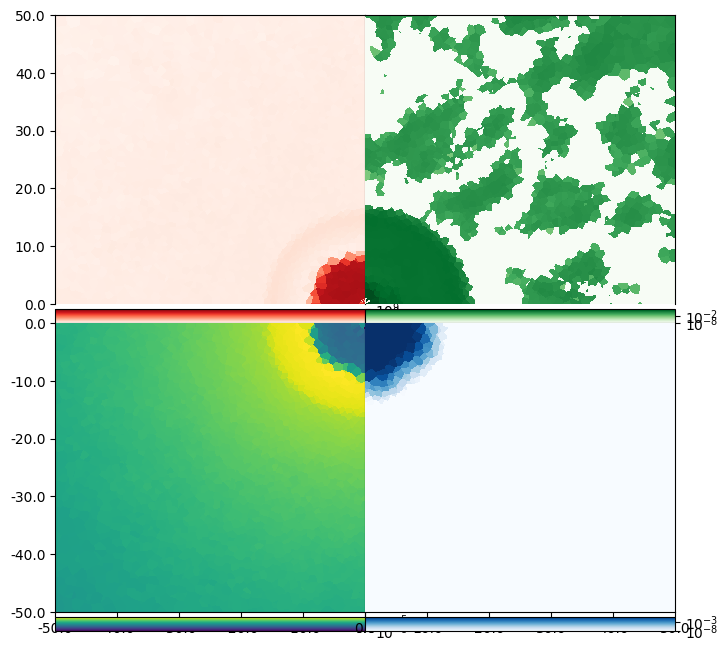

In [ ]:
BASE_PATH = '/cosma8/data/dp317/dc-naza3/gasCloudNfw'
SNAPBASE = 'snap_'
SNAPFILETYPE = '.hdf5'

GAMMA = 5/3 # heat capaticy ratio for monatomic gas
HYDROGENMASS_FRAC = 0.76

# k_B = const.k_B.to((u.Msun*1e10)*(u.km/u.s)**2/u.K).value
# m_p = const.m_p.to(u.Msun*1e10).value

k_B       = 1.381e-16
m_p       = 1.66e-24



## Set up figure & axis grid
fig = plt.figure(figsize=(8,8))

outer = gridspec.GridSpec(1, 1, wspace=0.2)
quad_subs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[0], hspace=0, wspace=0)


## Load the snapshot

snap_num = 10
output_path = BASE_PATH + '/output/'

s = load_snap_data(snap_num,snappath=output_path,snapbase=SNAPBASE)
snap_time = calc_snap_time(s)


## Set global figure options

image_proj = 'side'     # side or top viewing angle
plotsize =  50        # Size in kpc of one panel
proj_on = False         # Whether to do a slice or a projection
proj_fact = 0.1         # Fraction of plotsize to project through
res = 1024               # Pixels per panel


## Plot each axis quadrent
# Top left

# Here we're passing the same snap each time, but you could give each one a different snapshot to make e.g. a time series image

quad_TL = plot_quad_axis(
    s,
    fig,
    quad_subs,
    quad_ax_loc = [0,0],
    var = 'temp',
    weighted = 'rho', # or None
    ranges = [5e5,1e9],
    cmap = 'Reds',
    logplot = True,
    divzero = False,
    divzero_centre = None,

    image_proj = image_proj,
    proj_on = proj_on,
    proj_fact = proj_fact,
    res = res,
    plotsize = plotsize
    )


# Bottom left

quad_BL = plot_quad_axis(
    s,
    fig,
    quad_subs,
    quad_ax_loc = [1,0],
    var = 'rho',
    weighted = 'rho', # or None
    # ranges = [1e6,1e9],
    cmap = 'viridis',
    logplot = True,
    divzero = False,
    divzero_centre = None,

    image_proj = image_proj,
    proj_on = proj_on,
    proj_fact = proj_fact,
    res = res,
    plotsize = plotsize
    )


# Top right

quad_TR = plot_quad_axis(
    s,
    fig,
    quad_subs,
    quad_ax_loc = [0,1],
    var = 'vrad',
    weighted = 'rho', # or None
    # ranges = [1e6,1e9],
    cmap = 'Greens',
    logplot = True,
    divzero = False,
    divzero_centre = None,

    image_proj = image_proj,
    proj_on = proj_on,
    proj_fact = proj_fact,
    res = res,
    plotsize = plotsize
    )


# Bottom right

quad_BR = plot_quad_axis(
    s,
    fig,
    quad_subs,
    quad_ax_loc = [1,1],
    var = 'wind',
    weighted = 'rho', # or None
    # ranges = [1e6,1e9],
    cmap = 'Blues',
    logplot = True,
    divzero = False,
    divzero_centre = None,
    colorbar=False,
    image_proj = image_proj,
    proj_on = proj_on,
    proj_fact = proj_fact,
    res = res,
    plotsize = plotsize
    )
# fig.savefig('plots_new/quad_temp_snap{}_{}.png'.format(number_string(snap_num),image_proj),dpi=300)
# plt.show()